#### Visualizing Decision Boundry under logistic and decision trees
Here I am using the data set provided in Andrew NG's ML course

In [1]:
setwd("D:/Andrew_NG_ML/machine-learning-ex2/ex2")

In [2]:
list.files()

[1] "costFunction.m"         "costFunctionReg.m"      "ex2.m"                 
 [4] "ex2_reg.m"              "ex2data1.txt"           "ex2data2.txt"          
 [7] "lib"                    "mapFeature.m"           "plotData.m"            
[10] "plotDecisionBoundary.m" "predict.m"              "sigmoid.m"             
[13] "submit.m"

#### Classify Admission Status based on exam scores
This data is from the past admissions whether a person got admitted or not based on the scores from two exams.

In [27]:
## read train data
train <- read.csv("ex2data1.txt",sep = ",", header = F)
names(train) <- c("Exam1_Score","Exam2_Score","Status")
head(train)
train$Status <- as.factor(train$Status)
str(train)

Exam1_Score,Exam2_Score,Status
34.62366,78.02469,0
30.28671,43.89500,0
35.84741,72.90220,0
60.18260,86.30855,1
79.03274,75.34438,1
45.08328,56.31637,0


'data.frame':	100 obs. of  3 variables:
 $ Exam1_Score: num  34.6 30.3 35.8 60.2 79 ...
 $ Exam2_Score: num  78 43.9 72.9 86.3 75.3 ...
 $ Status     : Factor w/ 2 levels "0","1": 1 1 1 2 2 1 2 2 2 2 ...


### EDA and Visualization

In [28]:
table(train$Status)


 0  1 
40 60 

There are 100 records out of which 60 are positive and 40 are negative

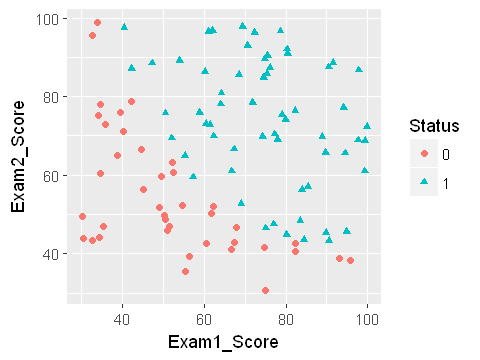

In [32]:
library(repr)
options(repr.plot.width=4, repr.plot.height=3)
# Above two lines are to set the size of the plot in the jupyter notebook

library(ggplot2)
ggplot(train, aes(x=Exam1_Score, y=Exam2_Score,color = Status,shape = Status)) +
  geom_point()

You can see that the data is linearly seperable. The red circles and blue triangles can be seperated one straight line.

#### Build a logistic regression 

In [53]:
logit_fit <- glm( Status ~ Exam1_Score + Exam2_Score, data = train, family = "binomial")
train$predict_prob <- predict(logit_fit,data = train, type = "response")

# predict_prob variables contain the predicted probabilities. I am just predicting on the train data

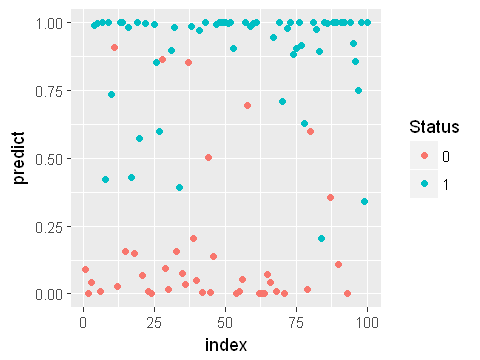

In [54]:
library(ggplot2)
ggplot(train, aes(y = predict, x = seq(1, length(train$predict)),color = Status,xlab = "index")) + geom_point() + labs(x = "index")

From this plot, we can see that Class = 1 have probabilities close to 1 where as Class = 0 have probabilites close to 0.
We can choose a threshold of 0.5 to choose Class = 1

In [55]:
train$predict_class <- as.factor(ifelse(train$predict_prob > 0.5, 1,0))

In [57]:
table(train$Status,train$predict_class)

   
     0  1
  0 34  6
  1  5 55

#### Plotting decision Boundry
Lets plot the decision boundry with the features and the cutoff threshold

In [58]:
logit_fit$coefficients

(Intercept) Exam1_Score Exam2_Score 
-25.1613335   0.2062317   0.2014716

In [110]:
Intercept = unname(logit_fit$coefficients)[1]/unname(logit_fit$coefficients)[2] * -1
Slope = unname(logit_fit$coefficients)[2]/unname(logit_fit$coefficients)[3] * -1

library(repr)
options(repr.plot.width=7, repr.plot.height=7)

sp <- ggplot(train, aes(x=Exam1_Score, y=Exam2_Score,color = Status,shape = Status)) +
  geom_point() 

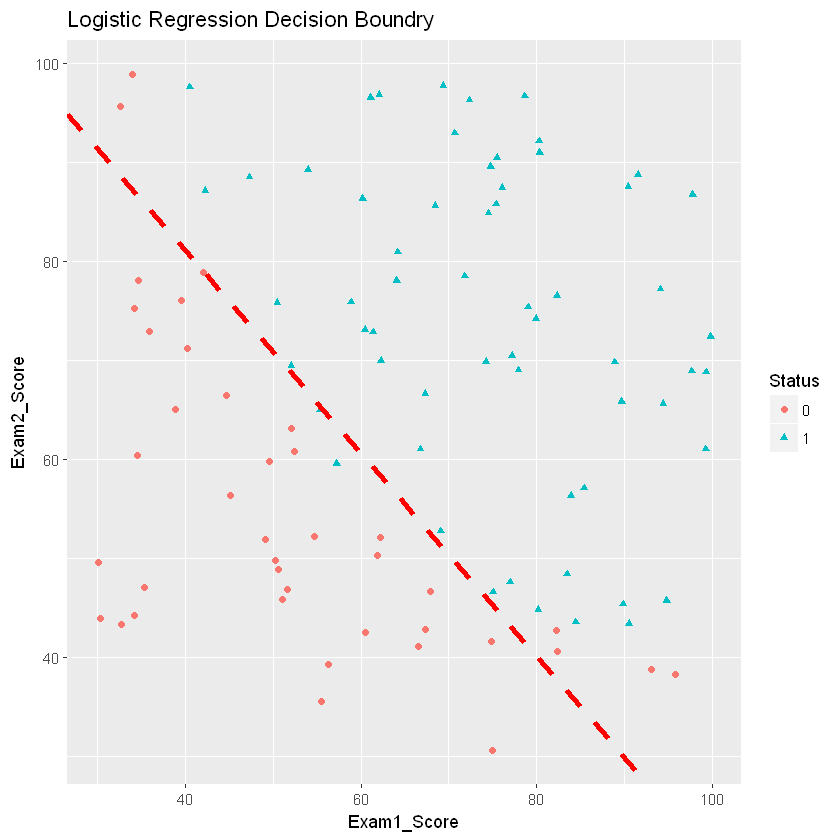

In [175]:
sp + geom_abline(intercept = Intercept, slope = Slope, color="red",linetype="dashed", size=1.5) + ggtitle("Logistic Regression Decision Boundry")

In [119]:
#### Lets build a decision tree
library(rpart)
rpart_fit <- rpart(Status ~ Exam1_Score + Exam2_Score, data = train,parms = list(split="information"))

In [120]:
printcp(rpart_fit)


Classification tree:
rpart(formula = Status ~ Exam1_Score + Exam2_Score, data = train, 
    parms = list(split = "information"))

Variables actually used in tree construction:
[1] Exam1_Score Exam2_Score

Root node error: 40/100 = 0.4

n= 100 

     CP nsplit rel error xerror     xstd
1 0.525      0     1.000  1.000 0.122474
2 0.225      1     0.475  0.675 0.110990
3 0.010      2     0.250  0.375 0.089268


Minimum cross validation error is when cp = 0.01. Lets prune the tree again with cp = 0.01

In [124]:
rpart_prune<- prune(rpart_fit, cp= 0.01)
train$predict_rpart <- predict(rpart_prune,data = train,type = "class")

In [127]:
print(rpart_prune)

n= 100 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 100 40 1 (0.40000000 0.60000000)  
  2) Exam1_Score< 56.74626 35  7 0 (0.80000000 0.20000000) *
  3) Exam1_Score>=56.74626 65 12 1 (0.18461538 0.81538462)  
    6) Exam2_Score< 43.11452 9  0 0 (1.00000000 0.00000000) *
    7) Exam2_Score>=43.11452 56  3 1 (0.05357143 0.94642857) *


In [180]:
#### This code is obtained from http://michael.hahsler.net

decisionplot <- function(model, data, class = NULL, predict_type = "class",
  resolution = 100, showgrid = TRUE, ...) {

  if(!is.null(class)) cl <- data[,class] else cl <- 1
  data <- data[,1:2]
  k <- length(unique(cl))

  plot(data, col = as.integer(cl)+1L, pch = as.integer(cl)+1L,...)

  # make grid
  r <- sapply(data, range, na.rm = TRUE)
  xs <- seq(r[1,1], r[2,1], length.out = resolution)
  ys <- seq(r[1,2], r[2,2], length.out = resolution)
  g <- cbind(rep(xs, each=resolution), rep(ys, time = resolution))
  colnames(g) <- colnames(r)
  g <- as.data.frame(g)

  ### guess how to get class labels from predict
  ### (unfortunately not very consistent between models)
  p <- predict(model, g, type = predict_type)
  if(is.list(p)) p <- p$class
  p <- as.factor(p)

  if(showgrid) points(g, col = as.integer(p)+1L, pch = ".")

  z <- matrix(as.integer(p), nrow = resolution, byrow = TRUE)
  contour(xs, ys, z, add = TRUE, drawlabels = FALSE,
    lwd = 2, levels = (1:(k-1))+.5)

  invisible(z)
}

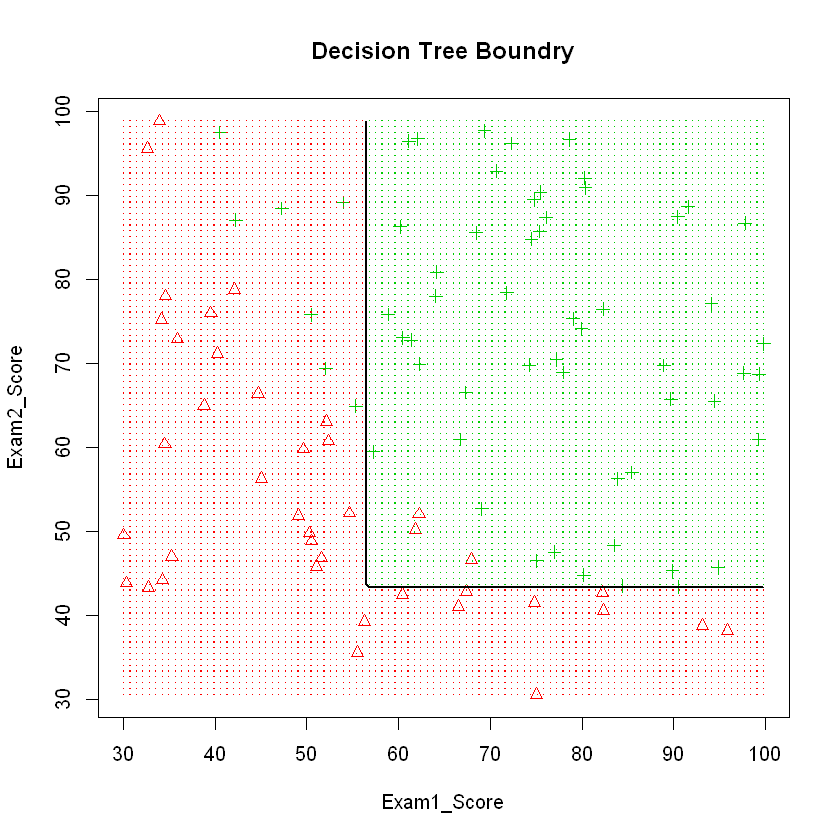

In [178]:
decisionplot(rpart_prune,train, class = "Status", main = "Decision Tree Boundry")

You can see that Decision Tree boundries are straight lines parallel to the axis. Logistic regression shape can take any
shape depending upon the hypothesis we are trying to fit. This is one of the major differences